# Forecasting Electricity Demand in Pittsburgh, PA

In this project, we will attempt to forecast Pittsburgh electrical demand through a combination of heuristic knowledge and historic demand data. Based on the assumption that this is a regression problem, our aim is to compare commonly used regression techniques using the same feature set. 

How much does the use of ensemble techniques matter when prediction quality and accuracy is concerned? How generalizable is the model we use? There are some questions we hope to answer through this exploratory project.

## Table of Contents

* [Motivation](#Motivation)
* [Packages and Dependencies](#Packages)
* [Data Sources and Collection](#DataCollection)
    * [Electric Demand Data](#elecdata)
    * [Weather Data](#weatherdata)
* [Data Aggregation](#dataagg)
* [Preliminary Data Visualization](#datavis)
* [Type Conversions and Pre-processing](#preprocess)
* [Preparing input data for Regression Methods](#tonumpy)
* [Feature Selection using Orthogonal Matching Pursuit](#omp)
* [Analysis - Simple Regression, Random Forest Regression, Bagging Regression](#regression)
    * [Preliminary Analysis](#prelim)
    * [Model Comparison](#comparison)
* [Comparing Forecast with PJM Forecast](#forecastcomparison)


## Motivation - Why predict energy demand? <a name = "Motivation"></a>

Conservation of energy and energy management for both environmental and economic factors is an age old problem. Using predicted energy demand, utilities can manage generation and peak load shaving techniques. However, inaccurate predictions can lead to surplus generation, or worse still, energy deficits. Additionally, the advent of renewable energy generation has led to application of hourly load predictions for demand response programs and associated monetary transactions. Energy demand prediction has implications in the renewable energy sector, as well as for energy infrastructure system development, such as the design or planning of microgrids with the availability of more granular, neighborhood specific data. 

For these reasons, we explore the difference in accuracy as a result of using different regression methods. 


## Packages and Dependencies <a name = "Packages"></a>

The various packages required to be installed for this project are listed here. 

#### For weather data collection
* PyPi package wwo-hist

#### For data preprocessing and visualization 
* pandas
* glob
* seaborn
* matplotlib

#### For regression models
* scikitlearn - sklearn

Each of these packages is imported below, and will be used to execute the various steps of this project.

In [78]:
#weather
from wwo_hist import retrieve_hist_data
#data processing and visualization
import pandas as pd
import glob
import os
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

import collections
import requests
import json
import time 
from tqdm import tqdm

## Data Sources and Collection <a name="DataCollection"></a>

To predict future electrical demand, two sources of data were considered most important -

1) Historic Electric Demand Data
2) Historic Weather Data

### Historic Electric Demand Data <a name = "elecdata"></a>

Historic Electric Demand Data for Pittsburgh is openly published by [PJM](https://www.pjm.com/markets-and-operations/etools/data-miner-2.aspx), the Regional Transmission Organization that oversees the city's electricity management. This data can be obtained programmatically, or downloaded as a CSV file. To gain access to developer tools or the API, one must be added to an authorized organization. However, the CSV download is free for all. For this reason, the project utilizes CSV data that from PJM's [DataMiner2 Interface](https://dataminer2.pjm.com/feed/hrl_load_metered). 
Using this interface, data was collected for a duration of three years, from May 1st 2016 to April 30th 2019. 

Yearly records were obtained in CSV format and are read in using the function `get_electric_load_city` below. A dataframe containing the historic demand data is also initialized here using the dataframe returned by this function. We can see that there are 26280 hourly instances

In [79]:
#returns dataframe of electric load data from csvs
#city can be defined based on stored directory
#files named starting with 'hrl_load_metered'
def get_electric_load_city(dirname = os.getcwd()):
    path = os.path.join(dirname, 'hrl_load_metered_')
    all_files = glob.glob(path + "*.csv")
    
    csv_list = []
    for filename in all_files:
        df = pd.read_csv(filename, header = 0)
        csv_list.append(df)
        
    electric_df = pd.concat(csv_list, axis = 0, ignore_index = True, sort = True)
    
    return electric_df

electric_df = get_electric_load_city()
print(electric_df.shape)
#printing out header rows to check columns created
electric_df.head()


(26280, 8)


,datetime_beginning_ept,datetime_beginning_utc,is_verified,load_area,mkt_region,mw,nerc_region,zone
0,5/1/2016 0:00,5/1/2016 4:00,True,DUQ,WEST,1138.573,RFC,DUQ
1,5/1/2016 1:00,5/1/2016 5:00,True,DUQ,WEST,1089.713,RFC,DUQ
2,5/1/2016 2:00,5/1/2016 6:00,True,DUQ,WEST,1075.268,RFC,DUQ
3,5/1/2016 3:00,5/1/2016 7:00,True,DUQ,WEST,1068.282,RFC,DUQ
4,5/1/2016 4:00,5/1/2016 8:00,True,DUQ,WEST,1062.133,RFC,DUQ




### Historic Weather Data <a name = "weatherdata"></a>

Weather data to be used for this prediction was obtained programmatically using PyPi package **wwo-hist**. wwo-hist uses data from [World Weather Online](https://www.worldweatheronline.com/developer/login.aspx?ReturnUrl=%2fdeveloper%2fmy%2f).  Documentation for the wwo-hist package can be found at https://pypi.org/project/wwo-hist/. 

To try this out, get a free API key (no billing information needed!) [here](https://www.worldweatheronline.com/developer/) and store it in a `.txt` file in your notebook directory. The function below reads the API, to use for the query. 



In [80]:
#using method from hw1 to hide api key
def read_api_key(filepath = "weather_api_key.txt"):
    with open(filepath) as f:
        lines = f.read()
        
    return lines.strip()

Now that we can get the API key, we use it to get historic weather data using the API and wwo-hist to get hourly weather data for the same duration as electric demand data, May 1st 2016 to May 1st 2019. Since these are hourly values and the end time cannot vary in the definition, the extra day will be dropped later. 

The function below returns a wwo-hist stored "dataframe", contained in a list where the first element is a dataframe. By setting the `export_csv` parameter to True in the `retrieve_hist_data` method, a csv file containing the same data as the dataframe is stored. This can be used to reduce the number of calls to the API.

In [81]:
#function to get weather data using wwo-hist package
#package code reference https://pypi.org/project/wwo-hist/
def get_wwohist_weather(location, start_date, end_date, frequency, api_key = read_api_key()):
    hist_weather = retrieve_hist_data(api_key,
                                  location,
                                  start_date,
                                  end_date,
                                  frequency,
                                  export_csv = True,
                                  store_df = True)
    return hist_weather

#weather data
hist_weather = get_wwohist_weather(['pittsburgh'], '01-MAY-2016','01-MAY-2019',1)
    



Retrieving weather data for pittsburgh


Currently retrieving data for pittsburgh: from 2016-05-01 to 2016-05-31
Time elapsed (hh:mm:ss.ms) 0:00:02.114400
Currently retrieving data for pittsburgh: from 2016-06-01 to 2016-06-30
Time elapsed (hh:mm:ss.ms) 0:00:04.282778
Currently retrieving data for pittsburgh: from 2016-07-01 to 2016-07-31
Time elapsed (hh:mm:ss.ms) 0:00:06.658796
Currently retrieving data for pittsburgh: from 2016-08-01 to 2016-08-31
Time elapsed (hh:mm:ss.ms) 0:00:09.128660
Currently retrieving data for pittsburgh: from 2016-09-01 to 2016-09-30
Time elapsed (hh:mm:ss.ms) 0:00:11.392186
Currently retrieving data for pittsburgh: from 2016-10-01 to 2016-10-31
Time elapsed (hh:mm:ss.ms) 0:00:13.535728
Currently retrieving data for pittsburgh: from 2016-11-01 to 2016-11-30
Time elapsed (hh:mm:ss.ms) 0:00:15.726244
Currently retrieving data for pittsburgh: from 2016-12-01 to 2016-12-31
Time elapsed (hh:mm:ss.ms) 0:00:18.233050
Currently retrieving data for pittsburgh: fro

The API exports the data to a csv file which we then read in to create the initial Dataframe

In [82]:
weather_df = pd.read_csv("pittsburgh.csv")
print(weather_df.dtypes)

date_time             object
maxtempC               int64
mintempC               int64
totalSnow_cm         float64
sunHour              float64
uvIndex                int64
uvIndex.1              int64
moon_illumination      int64
moonrise              object
moonset               object
sunrise               object
sunset                object
DewPointC              int64
FeelsLikeC             int64
HeatIndexC             int64
WindChillC             int64
WindGustKmph           int64
cloudcover             int64
humidity               int64
precipMM             float64
pressure               int64
tempC                  int64
visibility             int64
winddirDegree          int64
windspeedKmph          int64
dtype: object


## Data Aggregation <a name = "dataagg"></a>

Now that we have both data sources, we combine the sources so that hourly values for load and weather condtions are aligned. The function below is used to combine the two dataframes, and some columns that were immediately apparent to be irrelevant to the prediction problem were dropped in this process. 

In [83]:
def get_merged_load_weather(electric_df, weather_df):
    #converting date-time column to datetime object for east of manipulation
    electric_df["datetime_beginning_ept"] = electric_df["datetime_beginning_ept"].astype('datetime64[ns]')
    #setting index
    data = electric_df.set_index("datetime_beginning_ept").join(weather_df.set_index("date_time"))
    #removing columns that are clearly not relevant to the problem statement
    data = data.drop(columns = ['nerc_region', 'mkt_region', 'zone', 'load_area', 
                                'is_verified', 'datetime_beginning_utc', 'FeelsLikeC', 'visibility'])
    return data

#print data to check merge works
data = get_merged_load_weather(electric_df, weather_df)
print(data.shape)
data.head()



(26280, 23)


,mw,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,moon_illumination,moonrise,moonset,...,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,winddirDegree,windspeedKmph
2016-05-01 00:00:00,1138.573,20,11,0.0,11.0,1,1,29,02:09 AM,01:22 PM,...,12,10,19,100,98,0.0,1014,12,164,12
2016-05-01 01:00:00,1089.713,20,11,0.0,11.0,1,1,29,02:09 AM,01:22 PM,...,12,11,21,100,98,0.0,1014,12,172,13
2016-05-01 02:00:00,1075.268,20,11,0.0,11.0,1,1,29,02:09 AM,01:22 PM,...,13,12,23,100,98,0.0,1014,13,180,14
2016-05-01 03:00:00,1068.282,20,11,0.0,11.0,1,1,29,02:09 AM,01:22 PM,...,14,12,24,100,98,0.0,1013,14,188,15
2016-05-01 04:00:00,1062.133,20,11,0.0,11.0,1,1,29,02:09 AM,01:22 PM,...,14,13,22,100,98,0.0,1013,14,195,14


## Preliminary Data Visualization <a name = "datavis"></a>

From heuristic knowledge, we expected that temperature variables would be associated with the demand. To assess what other variables had an apparent relationship with the outcome variable (demand) and the type of relationship, pairwise visualizations were used. The three functions defined below were used for this purpose for different subsets of data, as applicable. 

The feature variables collected can be classified as two types - 

1) Features that might vary every hour of every day (mw demand, dew point temperature, cloud cover, windspeed etc..)

2) Features that are constant for a given day (max temperature, minimum temperature, daylight hours)


In [87]:
#returns data grouped by day
def get_data_day(data):
    return data.groupby([pd.Grouper(freq='D')], as_index=False).agg(['mean'])
    
#takes data grouped by day and returns visualization as pairwise matrix
def vis_corr_matrix(data_day):
    
    #code referenced from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
    sns.set(style="white")
    corr = data_day.corr()
    corr = corr.round(2)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))
    ax.set_title('Feature Correlation: Daily View')

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot = True, annot_kws = {"size": 12} ,square=True, 
                linewidths=.5, cbar_kws={"shrink": .5})
    
def vis_pairgrids(data_day):
    g = sns.PairGrid(data_day,
                     x_vars= data_day.drop(columns = ['mw']).columns,
                     y_vars=['mw'])

    g = g.map(plt.scatter)
    
#vis_pairgrids(get_data_day(data))
data_day = get_data_day(data)    

### Correlation Matrix

Since the first method that will be explored is a simple linear regression, a pairwise grid comparing the electric demand `mw` to each feature in the data, and the different features to each other, is generated below. The correlation value plotted in each cell of the grid is the Pearson Correlation Coefficient value for the corresponding pair of features. By looking at this grid, we can see that there is no strong linear correlation between any of the features and the demand. However, some strong collinearity between features exists, as can be seen in the chart. This will potentially reduce the performance of the simple linear regression model.

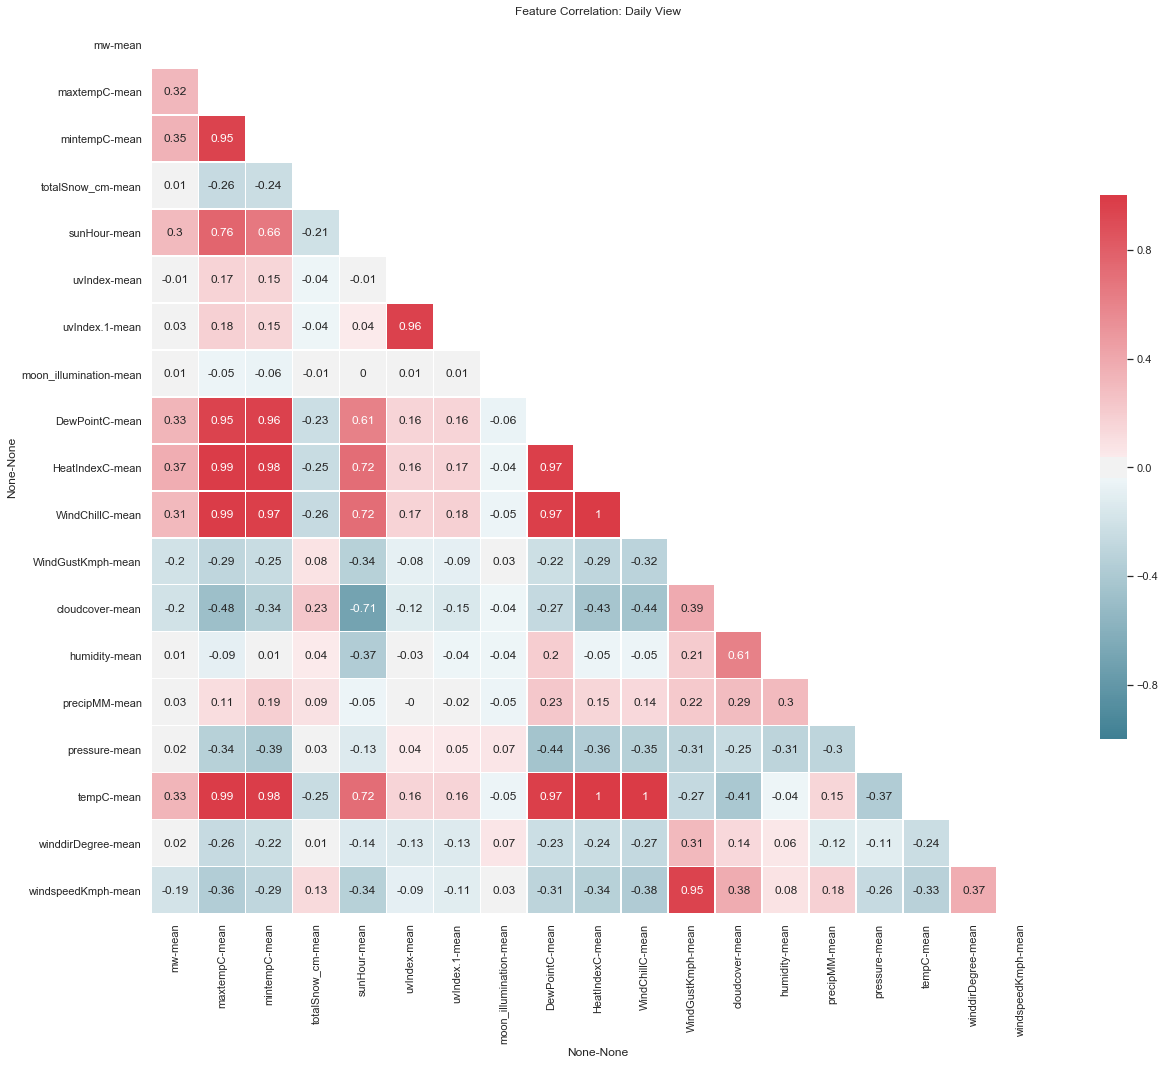

In [88]:
#we will use data_day for the visualization
data_day = get_data_day(data)
vis_corr_matrix(data_day)

Now, we plot pairwise charts to identify if any patterns exist. 
Due to the large number of feature columns, 4 features are plotted at a time by using subsets of the combined dataframe and the `vis_pairgrids` function. Features that are not numbers (such as sunrise time) are not plotted, as these values cannot be averaged.

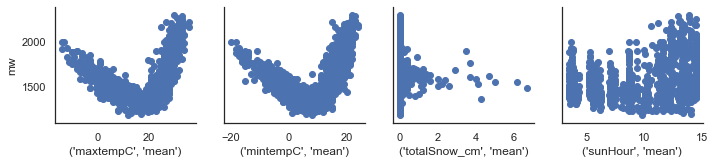

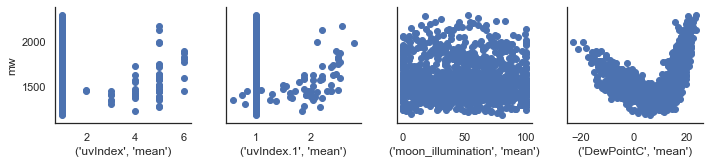

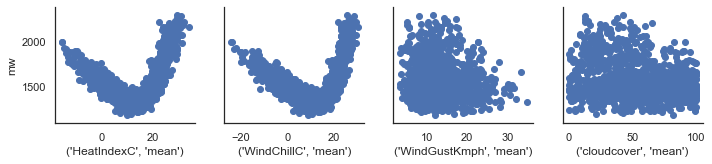

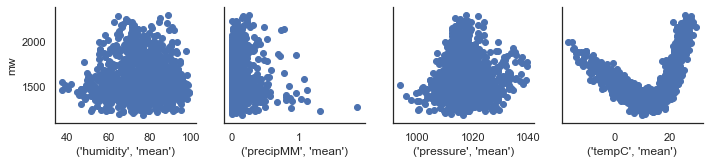

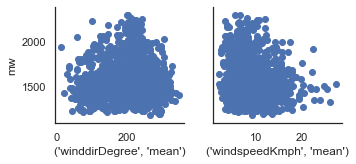

In [89]:
def vis_subset_pairgrids(data):
    mw = data['mw']
    #dropping outcome mw and non-numeric and irrelevant features
    all_features = data.drop(columns = ['mw'])
    num_cols = len(all_features.columns)
    #column subsets to make visualization clear
    for subset in range(4, (num_cols//4*4 + 4*(num_cols % 4 != 0)) + 4, 4):
        currFeatures = all_features.iloc[:, (subset - 4):subset]
        currDF = pd.concat([mw, currFeatures], axis = 1)
        currDF = get_data_day(currDF)
        #visualizing pairgrid of 4 features at a time
        vis_pairgrids(currDF)
        
    
vis_subset_pairgrids(data.drop(columns = ['moonrise','moonset','sunrise','sunset']))

From looking at the plots generated above, we can see definite polynomial trends in the temperature related terms. 

### Solar Irradiance Data

Lastly, we collect Solar irradiance data to observe any possible trends that may exist between irradiation and the energy demand. This is monthly aggregated data, based on historic data but not representative of separate moments in time. NREL's [Solar Resource Data API](https://developer.nrel.gov/docs/solar/solar-resource-v1/) is used to get this data. You can [get your own API key](https://developer.nrel.gov/signup/) and get free access. 

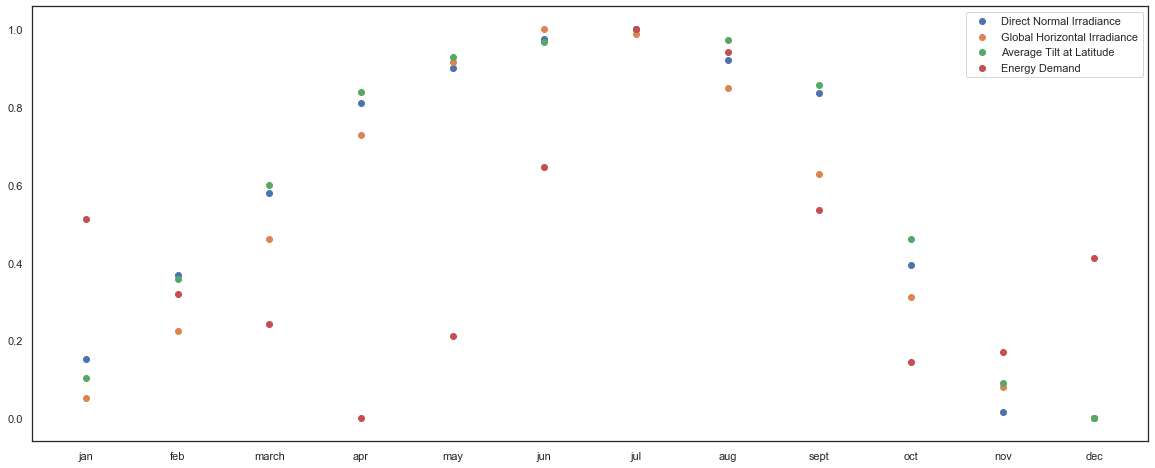

In [90]:
def get_solar_irradiance(lat, lon, api_key = read_api_key('solar_api_key.txt')):
    URL = 'https://developer.nrel.gov/api/solar/solar_resource/v1.json?lat=%s&lon=%s&api_key=%s&format=JSON'%(lat,lon,api_key)
    response = requests.get(URL)
    
    jsonresp = json.loads(response.content)
    return jsonresp

solar_data = get_solar_irradiance('40.44','-79.99')

months = ('jan','feb','march','apr','may','jun','jul','aug','sept','oct','nov','dec')
dni = np.asarray(list(solar_data['outputs']['avg_dni']['monthly'].values()))
ghi = np.asarray(list(solar_data['outputs']['avg_ghi']['monthly'].values()))
lat_tilt = np.asarray(list(solar_data['outputs']['avg_lat_tilt']['monthly'].values()))

data2 = data.copy()
data2['month'] = [d.month for d in data.index]
demand = data2.groupby('month')
demand_vals = demand['mw'].agg(np.mean).to_numpy()

demand_vals = (demand_vals - np.min(demand_vals))/(np.max(demand_vals) - np.min(demand_vals))
dni = (dni - np.min(dni))/(np.max(dni) - np.min(dni))
ghi = (ghi - np.min(ghi))/(np.max(ghi) - np.min(ghi))
lat_tilt = (lat_tilt - np.min(lat_tilt))/(np.max(lat_tilt) - np.min(lat_tilt))


plt.figure(figsize = (20,8))
plt.scatter(months,dni, label = 'Direct Normal Irradiance')
plt.scatter(months,ghi, label = 'Global Horizontal Irradiance')
plt.scatter(months,lat_tilt, label = 'Average Tilt at Latitude')
plt.scatter(months,demand_vals, label = 'Energy Demand')
plt.legend()


As depicted by the graph, there does not appear to be any visible trends so we will disregard this information moving forward. 

## Type Conversion and Pre-processing <a name = "preprocess"></a>
 
As noticed from the pairwise plots above, some features do not behave linearly with respect to the outcome variable. For these features, a squared term is added.
Other feature columns which do not make sense heuristically from the plots are dropped from the feature set as well. 

Other features which might be useful are added, namely:

1) `is_weekend` - Boolean variable, 0 if weekday and 1 if weekend

3) `month` - From date time 

4) `hour of day` - From date time 

2) `temprange` - Temperature range defined by max temp - min temp

By splitting the data in this fashion, we will be able to group data in terms of "weekend vs weekday" or by month and compare values accordingly. 

The function below does this pre-processing. The prepared data is then stored in variable `pr_data`, which will be used in place of `data` for the rest of the project.

In [91]:
#Prepares data model for prediction
def prepare_data(data):
    #adding month, hour of day and is_weekend
    data['month'] = [d.month for d in data.index]
    data['hour_of_day'] = [d.hour for d in data.index]
    data['day_of_week'] = [d.dayofweek for d in data.index]
    #is_weekend
    data['is_weekend'] = [0 for d in data.index]
    data.loc[data['day_of_week'] > 4, 'is_weekend'] = 1
    #adding temp_range
    data['temp_range'] = data['maxtempC'] - data['mintempC']
    #dropping columns    
    dropped_columns = ['sunrise', 'sunset', 'moonrise', 'moonset', 'moon_illumination', 'winddirDegree','day_of_week']
    data = data.drop(columns = dropped_columns)
    
    #squaring columns with strong but non linear trends
    data['temp_range^2'] = data['temp_range']**2
    data['maxtempC^2'] = data['maxtempC']**2
    data['mintempC^2'] = data['mintempC']**2
    data['DewPointC^2'] = data['DewPointC']**2
    data['HeatIndexC^2'] = data['HeatIndexC']**2
    data['WindChillC^2'] = data['WindChillC']**2
    data['tempC^2'] = data['tempC']**2
    
    
    return data


In [92]:
#prepared data
pr_data = prepare_data(data)
pr_data.head()

,mw,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex.1,DewPointC,HeatIndexC,WindChillC,...,hour_of_day,is_weekend,temp_range,temp_range^2,maxtempC^2,mintempC^2,DewPointC^2,HeatIndexC^2,WindChillC^2,tempC^2
2016-05-01 00:00:00,1138.573,20,11,0.0,11.0,1,1,11,12,10,...,0,1,9,81,400,121,121,144,100,144
2016-05-01 01:00:00,1089.713,20,11,0.0,11.0,1,1,12,12,11,...,1,1,9,81,400,121,144,144,121,144
2016-05-01 02:00:00,1075.268,20,11,0.0,11.0,1,1,13,13,12,...,2,1,9,81,400,121,169,169,144,169
2016-05-01 03:00:00,1068.282,20,11,0.0,11.0,1,1,13,14,12,...,3,1,9,81,400,121,169,196,144,196
2016-05-01 04:00:00,1062.133,20,11,0.0,11.0,1,1,14,14,13,...,4,1,9,81,400,121,196,196,169,196


Pairwise plots are now generated for the new features

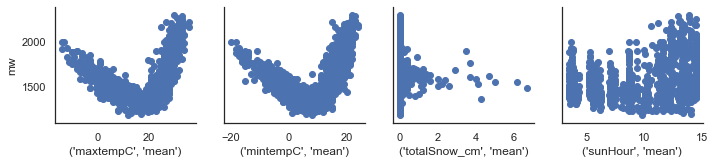

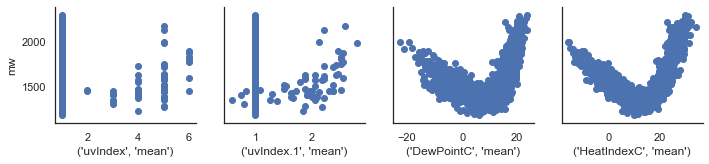

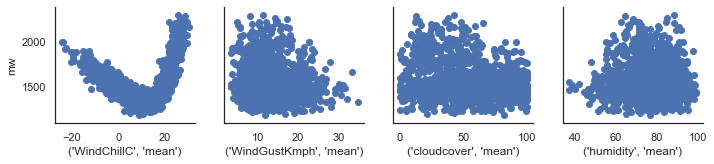

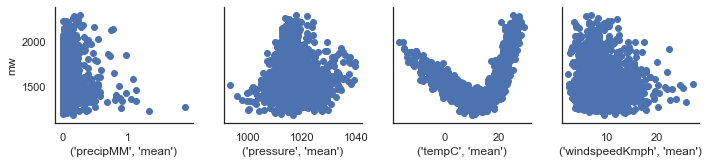

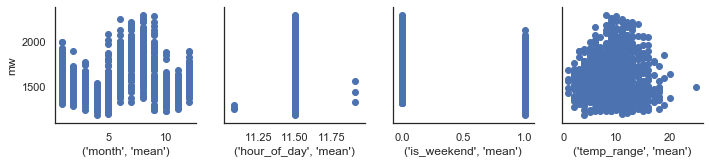

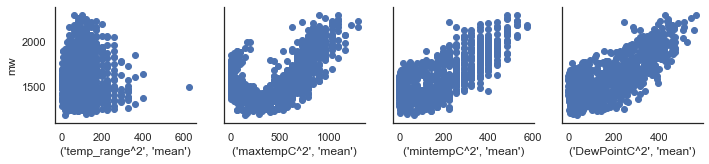

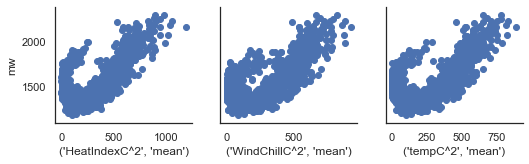

In [93]:
vis_subset_pairgrids(pr_data)

From the new plots, we can see that adding the squared term would better resemble a linear relationship. Higher degree terms are avoided to prevent overfitting. This is an instance of modeling a non-linear relationship/problem while still using linear regression methods. In some cases, for discrete variables like day of week and isweekend, these scatter plots are not meaningful.

At the end of this pre-processing, we are left with a dataframe that contains only numeric values, ready to be converted as an array to be used for regression models.

## Preparing Input Data for Regression Methods <a name = "tonumpy"></a>

We convert the pre-processed data into numpy arrays and split into X and y, where X and y are 32 bit floating point `np.ndarray` of all the features and the outcome variable (electric demand) respectively.
The data is then standardized using sklearn's `MinMaxScaler()` method, to make the features comparable. It is then normalized. 

In [94]:
#helper function to standardize, then normalize feature data
#called in get_Xy
def standardize_data(X):
    X = MinMaxScaler().fit_transform(X)
    X = normalize(X)
    return X

#Returns arrays of features(X) and demand values(y)
def get_Xy(data):
    X = data.drop(columns = ['mw'])
    X = X.to_numpy(dtype = np.float32)
    X = standardize_data(X)
    
    y = data["mw"].to_numpy(dtype = np.float32)
    return(X, y)

In [95]:
#getting prepared data as numpy ndarrays
X , y = get_Xy(pr_data)

The function below splits given data into test and train sets for any given test size. This function is used later, once the model is defined, to explore the optimum split size for this data. Currently, a default value of 20% for test data size is used.

In [96]:
#returns train and test data in format (x_train, x_test, y_train, y_test)
#Splitting data - not shuffling, since it is a time series problem
def split_data(X,y,test_size = 0.2):
    #https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    return train_test_split(X,y,test_size = test_size, shuffle = False)

## Feature Selection using Orthogonal Matching Pursuit <a name = "omp"></a>

Orthogonal Matching Pursuit (OMP) was utilized to select the top "k" number of features in a specific regression instance. 
*"OMP tends to select only one from correlated features, because the next selected feature relies on a residual that is orthogonal to previous selected features."*<sup>[1]</sup>
OMP can be visualized in terms of signals. It takes a target signal (y, in this case) and tries to best fit the feature "signals" to the target given certain constraints. 

Sklearn's `OrthogonalMatchingPursuit` class can be used to create an OMP object, which can then be used to `fit` the training X and y, and get coefficients that allow us to determine whether a feature should be retained or not. The OMP object is initialized using a certain number of non-zero coefficients, **k**. The features which have the non-zero coefficients are the top k features. 

The functions defined below are used later in the project to perform the feature selection given some k, and a new feature array which contains only the top 'k' feature values for all hours is returned. 


In [97]:
#helper function for get_top_N_features
def X_after_OMP(X, dropped_indices):
    X = np.delete(X, dropped_indices, axis = 1)
    return X

#returns top N features using OMP 
def get_top_N_features(N, X_train, X, y_train):
    
    #initializing model
    omp_model = OrthogonalMatchingPursuit(n_nonzero_coefs = N)
    
    #fit using training data
    omp_model.fit(X_train, y_train)
    dropped_indices = []
    feature_idx_coef = collections.defaultdict(list)
    coefs = omp_model.coef_
    
    #storing indices
    for i, coef in enumerate(coefs):
        if coef == 0:
            dropped_indices.append(i)
        else:
            feature_idx_coef[i] = coef
    #getting new feature array with only top 'k' features
    X_new = X_after_OMP(X, dropped_indices)

    return (X_new, coefs)
    


To understand how this function works, we can look at a specific example. Say, we want to get the top 5 features. We can call this function with the argument N and the training data to get the top 5 features. With a little tweaking with the dataframe, we can also get the names of these features. We can see that OMP returns the top 5 features (not in order of importance, but in the order in which they are stored in the array/dataframe) to be `maxtempC`, `hour_of_day`,`is_weekend`,`DewPointC^2` and `WindChillC^2`. 

In [98]:
#temporary, for illustration
ex_X_train, ex_X_test, ex_y_train, ex_y_test = split_data(X,y)
X_new, coefs = get_top_N_features(5 ,ex_X_train, X, ex_y_train)
coef_df = pd.DataFrame({'feature' : pr_data.columns.values[1:],
                        'coef' : list(coefs)})
coef_df = coef_df[coef_df['coef'] != 0]
coef_df

,feature,coef
0,maxtempC,-1292.386011
17,hour_of_day,806.190523
18,is_weekend,-273.067906
23,DewPointC^2,775.111549
25,WindChillC^2,2988.140369


Now that we understand how the feature selection works, we can move on to assessing model performance for different regression models for a varying number of features

## Analysis -  Simple regression, Random Forest regression and Bagging Regression <a name = "regression"></a>

### Preliminary Analysis <a name = "prelim"></a>
In this section of the project, sklearn is used to fit different regression models - Simple Regression, Random Forest Regression and Bagging Regression - to the training data. The Models are evaluated using MSE (Mean Squared Error) and R-squared ($R^2$) for each of the models.

This comparison is done across a varying number of features. The MSE is then plotted below for parametrically varying number of features. To do the parametric runs, the functions below are utilized. `performance_analysis` takes X, y, a test size, and string input for type of regression model, and returns a tuple of two lists containing $R^2$ values and MSE values for that specific model, respectively.

The model parameter is a string, which can be 'lr' (linear regressor), 'br' (bagging regressor) or 'rf' (random forest regressor). For bagging regressor, the default base estimator, that is decision tree, was retained.

Some default input values used in the function are discussed later in this sub-section.

In [99]:
#helper function for performance_analysis
#returns R^2 and MSE values
def get_prediction_performance(y_target, y_pred):
    rsq = r2_score(y_target, y_pred)
    mse = mean_squared_error(y_target, y_pred)
    return rsq, mse

def performance_analysis(X, y, test_size, model):
    #splitting into training and testing parts
    Xtr,Xte,Ytr,Yte = split_data(X,y, test_size)
    #initializing empty lists for R^2 and MSE values
    rsq_vals= []
    mse_vals= []
    
    #Parametrically varying number of features
    for i in tqdm(range(1,X.shape[1])):
        X_new, coefs = get_top_N_features(i ,Xtr, X, Ytr)
        X_train, X_test, y_train, y_test = split_data(X_new,y, test_size)
        
        #Fitting model based on 'model' parameter
        #linear regressor
        if model == 'lr':
            currModel = LinearRegression()
            currModel.fit(X_train, y_train)
        #random forest regressor
        elif model == 'rf':
            currModel = RandomForestRegressor(n_estimators = 100)
            currModel.fit(X_train, y_train)
        #bagging regressor
        elif model == "br":
            #default base estimator - decision tree. Retained
            currModel = BaggingRegressor(n_estimators = 100)
            currModel.fit(X_train, y_train)
            
        #getting predicted values
        y_pred = currModel.predict(X_test)
        rsq, mse= get_prediction_performance(y_test, y_pred)
        rsq_vals.append(rsq)
        mse_vals.append(mse)
    
    return (rsq_vals, mse_vals)

#### Test size selection

One of the important input parameters for the function above is the test size. To check which training data size would give us the best performance, several input proportions for test size were tested, between 20% and 35%. The code block below evaluates what test_size should be passed to the function for more accuracy.

In [100]:
#arriving at test_size
test_size = [0.20,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35]

ideal = 0
max_r2 = 0
for i in test_size:
    rsq_vals, mse_vals = performance_analysis(X,y,i,'lr')
    maxval = np.amax(rsq_vals)
    if (maxval > max_r2):
        max_r2 = maxval
        ideal = i

print("ideal test size: " , ideal)
print("maximum R square: ", max_r2)

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 41.41it/s]


ideal test size:  0.29
maximum R square:  0.7074602385050497


From the results, we proceed with 29% of testing data and 71% training data. Since we are comparing the three models to each other, the same proportion is used for all three models. 

#### Number of Estimators for Random Forest

The default number of estimators (`n_estimators`) is 10 (or 100 for v 0.22). Using more estimators can increase the time required to run the model. The following code block was used to determine the approximately appropriate number of trees.

In [101]:

X_train_rf, X_test_rf, y_train_rf, y_test_rf = split_data(X,y,0.29)
#arriving at n_estimators
res_dict = collections.defaultdict(list)
for n_estimators in tqdm([10,20,50,100,150,200]):
    t1 = time.time()
    curr_rf = RandomForestRegressor(n_estimators = n_estimators)
    curr_rf.fit(X_train_rf, y_train_rf)
    y_pred_rf = curr_rf.predict(X_test_rf)
    t2 = time.time()
    print("For %d decision trees : "%(n_estimators))
    tt = t2 - t1
    res_dict['time'].append(tt)
    print("Time taken : ", tt)
    pp = get_prediction_performance(y_test_rf, y_pred_rf)
    print("R^2 : ", pp[0])
    res_dict['r2'].append(pp[0])
    print("MSE : ",pp[1], "\n")
    res_dict['mse'].append(pp[1])

  0%|                                                                                         | 0/6 [00:00<?, ?it/s]

For 10 decision trees : 
Time taken :  5.979252815246582
R^2 :  0.8996136043553123
MSE :  9105.614045895029 



 17%|█████████████▌                                                                   | 1/6 [00:05<00:29,  5.99s/it]

For 20 decision trees : 
Time taken :  10.528319597244263
R^2 :  0.9060330881200915
MSE :  8523.3305486086 



 33%|███████████████████████████                                                      | 2/6 [00:16<00:29,  7.36s/it]

For 50 decision trees : 
Time taken :  24.537088632583618
R^2 :  0.9090804449778762
MSE :  8246.918040430575 



 50%|████████████████████████████████████████▌                                        | 3/6 [00:41<00:37, 12.51s/it]

For 100 decision trees : 
Time taken :  51.71910333633423
R^2 :  0.9105362373431153
MSE :  8114.869436397161 



 67%|██████████████████████████████████████████████████████                           | 4/6 [01:32<00:48, 24.28s/it]

For 150 decision trees : 
Time taken :  71.44710040092468
R^2 :  0.9107629747871762
MSE :  8094.303067397531 



 83%|███████████████████████████████████████████████████████████████████▌             | 5/6 [02:44<00:38, 38.43s/it]

For 200 decision trees : 
Time taken :  95.88126516342163
R^2 :  0.9117168482225406
MSE :  8007.781350034524 



100%|█████████████████████████████████████████████████████████████████████████████████| 6/6 [04:20<00:00, 55.67s/it]


We plot the change in R-squared with increasing number of estimators first, to check the impact of more estimators. The R-squared shows an increase in trend, but the difference in these values is very marginal. The maximum possible $R^2$ value is a 1.2 percentage point increase in the degree to which the regression model can explain variability.

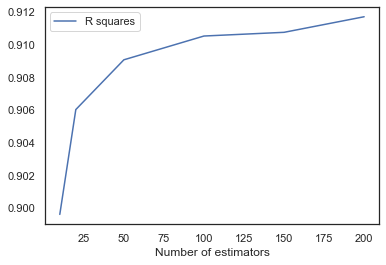

0.012103243867228275


In [102]:
plt.plot([10,20,50,100,150,200], res_dict['r2'], label = 'R squares')
plt.xlabel('Number of estimators')
# plt.ylabel('Time Taken')
plt.legend()
plt.show()

print(max(res_dict['r2']) - min(res_dict['r2']))

Next, the normalized values for time taken, $R^2$ and MSE were plotted together. From both these charts, we can conclude that the new default 100 is the best possible value for the number of estimators. 

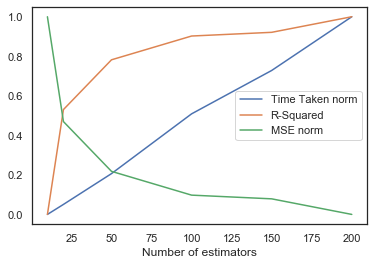

In [103]:
time_norm = np.asarray(res_dict['time'])
time_norm = (time_norm - np.min(time_norm))/(np.max(time_norm) - np.min(time_norm))

mse_norm = np.asarray(res_dict['mse'])
mse_norm = (mse_norm - np.min(mse_norm)) /(np.max(mse_norm) - np.min(mse_norm))

r2_norm = np.asarray(res_dict['r2'])
r2_norm = (r2_norm - np.min(r2_norm))/(np.max(r2_norm) - np.min(r2_norm))
plt.plot([10,20,50,100,150,200], time_norm, label = 'Time Taken norm')
plt.plot([10,20,50,100,150,200], r2_norm, label = 'R-Squared')
plt.plot([10,20,50,100,150,200], mse_norm, label = "MSE norm")
plt.xlabel('Number of estimators')
# plt.ylabel('Time Taken')
plt.legend()
plt.show()

A similar analysis conducted to check the impact of number of estimators on bagging regression performance. The code below runs this analysis. 

In [104]:
X_train_br, X_test_br, y_train_br, y_test_br = split_data(X,y,0.29)
#arriving at n_estimators
res_dict_br = collections.defaultdict(list)
for n_estimators in tqdm([10,20,50,100,150]):
    t1 = time.time()
    curr_br = BaggingRegressor(n_estimators = n_estimators)
    curr_br.fit(X_train_br, y_train_br)
    y_pred_br = curr_br.predict(X_test_br)
    t2 = time.time()
    
    print("For %d decision trees : "%(n_estimators))
    tt = t2 - t1
    res_dict_br['time'].append(tt)
    print("Time taken : ", tt)
    
    pp = get_prediction_performance(y_test_br, y_pred_br)
    print("R^2 : ", pp[0])
    res_dict_br['r2'].append(pp[0])
    print("MSE : ",pp[1], "\n")
    res_dict_br['mse'].append(pp[1])    

  0%|                                                                                         | 0/5 [00:00<?, ?it/s]

For 10 decision trees : 
Time taken :  4.704850673675537
R^2 :  0.8973063583879253
MSE :  9314.89430895313 



 20%|████████████████▏                                                                | 1/5 [00:04<00:18,  4.72s/it]

For 20 decision trees : 
Time taken :  9.207873582839966
R^2 :  0.906523037128398
MSE :  8478.889401547214 



 40%|████████████████████████████████▍                                                | 2/5 [00:13<00:18,  6.07s/it]

For 50 decision trees : 
Time taken :  23.16132378578186
R^2 :  0.9096632280991318
MSE :  8194.056314092706 



 60%|████████████████████████████████████████████████▌                                | 3/5 [00:37<00:22, 11.20s/it]

For 100 decision trees : 
Time taken :  47.36996364593506
R^2 :  0.9101319260777841
MSE :  8151.542755653917 



 80%|████████████████████████████████████████████████████████████████▊                | 4/5 [01:24<00:22, 22.06s/it]

For 150 decision trees : 
Time taken :  72.95305824279785
R^2 :  0.9112326497709462
MSE :  8051.700889066919 



100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [02:37<00:00, 37.33s/it]


A similar normalized plot is generated for the bagging regressor. From this chart, we stop seeing steep benefits when the number of estimators is ~100.

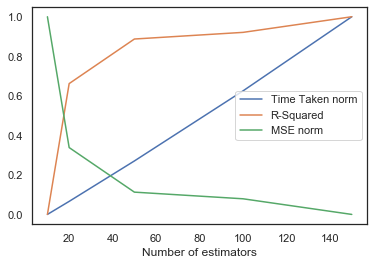

In [105]:
time_norm = np.asarray(res_dict_br['time'])
time_norm = (time_norm - np.min(time_norm))/(np.max(time_norm) - np.min(time_norm))

mse_norm = np.asarray(res_dict_br['mse'])
mse_norm = (mse_norm - np.min(mse_norm)) /(np.max(mse_norm) - np.min(mse_norm))

r2_norm = np.asarray(res_dict_br['r2'])
r2_norm = (r2_norm - np.min(r2_norm))/(np.max(r2_norm) - np.min(r2_norm))

#generating plot
plt.plot([10,20,50,100,150], time_norm, label = 'Time Taken norm')
plt.plot([10,20,50,100,150], r2_norm, label = 'R-Squared')
plt.plot([10,20,50,100,150], mse_norm, label = "MSE norm")
plt.xlabel('Number of estimators')
# plt.ylabel('Time Taken')
plt.legend()
plt.show()

## Model Comparison <a name = "comparison"></a>

Using the functions defined above, models were fit and evaluated for varying top 'k' features. 

In [106]:
#iteratively running models for 1 to 30 features
#Linear regression
rsq_vals_lr, mse_vals_lr = performance_analysis(X,y,0.29,"lr")

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 42.43it/s]


In [107]:
#random forest
rsq_vals_rf, mse_vals_rf = performance_analysis(X,y,0.29,"rf")

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [10:06<00:00, 41.24s/it]


In [108]:
#bagging regression
rsq_vals_br, mse_vals_br = performance_analysis(X,y,0.29,"br")

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [10:56<00:00, 43.28s/it]


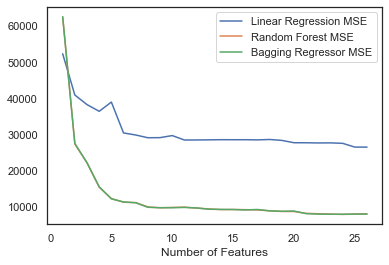

In [109]:
#Plotting MSE values for all three models for varying number of predictors
num_features= list(range(1,X.shape[1]))
plt.plot(num_features, mse_vals_lr, label = "Linear Regression MSE")
plt.plot(num_features, mse_vals_rf, label = "Random Forest MSE")
plt.plot(num_features, mse_vals_br, label = "Bagging Regressor MSE")
plt.legend()
plt.xlabel('Number of Features')
plt.show()

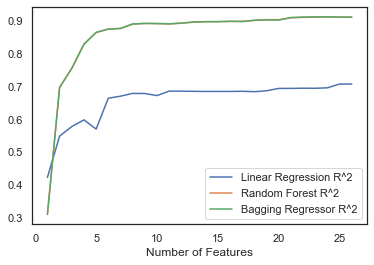

In [110]:
# for i in range(len(rsq_vals_lr)):
#     print(str(i+1) + " : " + str(rsq_vals_lr[i]) + str(rsq_vals_rf[i]) + str(rsq_vals_br[i]))
plt.plot(num_features, rsq_vals_lr, label = "Linear Regression R^2")
plt.plot(num_features, rsq_vals_rf, label = "Random Forest R^2")
plt.plot(num_features, rsq_vals_br, label = "Bagging Regressor R^2")
plt.legend()
plt.xlabel('Number of Features')
plt.show()

From looking at the charts generated above, we can see that the performance improvement plateaus at around 6 features. The ensemble methods perform much better with these features than the simple regression model.Therefore, from this analysis, a bagging regressor with the top 6 features would be ideal. The predicted and observed values are plotted below. A dataframe with the top 6 features (not in order) is also shown below.

In [111]:
X_train_br, X_test_br, y_train_br, y_test_br = split_data(X,y,0.29)
X_new_br, coefs = get_top_N_features(6 ,X_train_br, X, y_train_br)
X_train_br, X_test_br, y_train_br, y_test_br = split_data(X_new_br, y, 0.29)
br_model = BaggingRegressor(n_estimators = 100)
br_model.fit(X_train_br, y_train_br)

y_pred_br = br_model.predict(X_test_br)


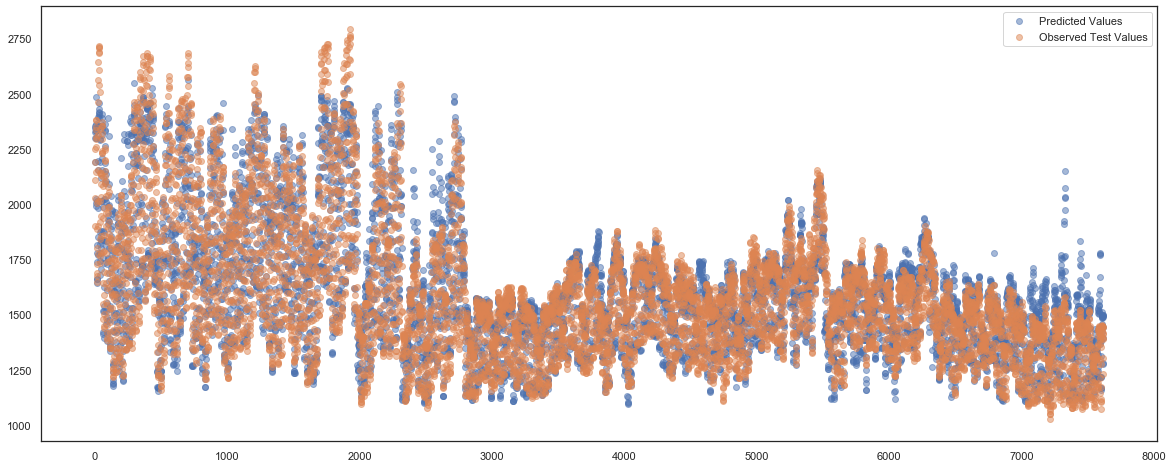

In [112]:
#Plotting predicted and observed values
x = np.arange(0,len(y_test_br))
plt.figure(figsize = (20,8))
plt.scatter(x,y_pred_br,alpha = 0.5, label = 'Predicted Values')
plt.scatter(x,y_test_br, alpha = 0.5, label = 'Observed Test Values')
plt.legend()


In [113]:
#Printing top 6 features 
coef_df = pd.DataFrame({'feature' : pr_data.columns.values[1:],
                        'coef' : list(coefs)})
coef_df = coef_df[coef_df['coef'] != 0]
coef_df

,feature,coef
0,maxtempC,-2317.904817
17,hour_of_day,664.853790
18,is_weekend,-324.158969
23,DewPointC^2,757.154345
24,HeatIndexC^2,6875.269580
25,WindChillC^2,-2068.438084


## Conclusion 

The findings of this project also a methodology framework for other energy prediction problems, such as building energy demand prediction with more granular indoor environmental features and occupancy patterns. Through this project, we were able to test a variety of models in their performance of predicting electricity output when taking into consideration weather conditions as well as yield insights into the features that provide the greatest impact for predictive performance. 

## References

1) [1] Shi, Xiaoshuang, et al. "Structured orthogonal matching pursuit for feature selection." Neurocomputing 349 (2019): 164-172.

2) Scikit-learn documentation for regression, OMP and accuracy metrics:  https://scikit-learn.org/

3) PJM DataMiner2 Documentation

4) wwo-hist documentation: https://pypi.org/project/wwo-hist/

5) Seaborn Official Documentation: https://seaborn.pydata.org/examples/many_pairwise_correlations.html